<center><b><h2>Project 1: Radiative Transfer</h2></center></b>
<center><h4>PHY4905/5905: Computational Physics-Spring 2022</h4></center>
<center><h4>Author: Pratiksha Balasaheb Gaikwad</center></h4>

In [29]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import LineString

import numpy as np
import math
import time
import random
import warnings

<center><h4><b>Optical depth (distance traveled before interaction)</b></center></h4>

A population of photons propagating through a medium will interact after traversing different distances s, distributed
according to an exponential, **non-uniform PDF:** $$p(s) = \tau {\rm e}^{-\tau s}$$ 

Here, $q(z)=1$ is a uniform distribution on [0,1) by definition, and we want to end up with $p(s) = \tau {\rm e}^{-\tau s}$ defined from 0 to $\infty$.
<br>

\begin{equation}
\left | p(s) ds \right | =  \left | q(z) dz \right |
\end{equation}



\begin{equation}
\int_{-\infty}^s p(s') ds' = \int_{-\infty}^z q(z') dz'
\end{equation}

To find s(z) that will yield an exponential distribution in x when z are drawn uniformly from 0 to 1.




\begin{aligned}
\tau \int_0^s {\rm e}^{-\tau s'} ds' &= \int_0^z dz' = z\\
1 - e^{-\tau s}  &= z\\
s &= - {1 \over \tau} \ln(1 - z) 
\end{aligned}

So, to generate random numbers $s$ according to an exponential distribution, we simply need to generate uniform random numbers $z$ and then transform them according to the above equation. 

<center><h4><b>Generate Scattering Angle (for 2D: Azimuthal Angle) ($\phi$) using random number</b></center></h4>

Note that if we use random numbers $x_i$ drawn from [0,1], we must transform them to the correct interval [a,b] using
\begin{equation}
x = x_i ( b - a ) + a 
\end{equation}

\begin{equation}
\phi = x_i ( 2\pi ) + (-\pi) , \quad \phi \in [-\pi, \pi] 
\end{equation}

<center><h4><b>Extending the calculation to 3D</b>, 
assuming spherical symmetry around the star.</center></h4>

Because the differential surface element in spherical coordinates $d\Omega = sin(\theta)d\theta d\phi$ depends on the polar angle $\theta$, its probability distribution is not uniform. In order to draw uniformly distributed points on a sphere, we define a random variable $z$ that is uniform in $[0.0,1.0)$ and we use the transformation method to find a function $\theta(z)$ that returns the correct probability distribution $p(\theta) = sin(\theta)/2.$



Here,  $q(z)=1$  is a uniform distribution on $[0,1)$ by definition, and we want to end up with $p(\theta) = sin(\theta)/2$ defined from $0$ to  $\pi$.

To find $\theta(z)$ that will yield an sinusodial distribution in $\theta$ when $z$ are drawn uniformly from $0$ to 1:

$$\int_0^\theta \frac{sin(\theta')}{2} d\theta' = \int_0^z dz'=z$$  
$$\frac{1}{2}[-cos(\theta')+C]^\theta_0 = z$$  
$$\frac{1-cos(\theta)}{2} = z$$
$$ \theta = cos^{-1}(1-2z)$$

In [30]:
def move2D(s,phi,x,y):
    '''Function to generate new cartesian coordinates in 2-dimensional space.
    
    Inputs:
    s: Distance (arbitrary unit)
    phi: Azimuthal angle (radians)
    x, y: Old cartesian coordinates (arbitrary distance units)

    Outputs:
    x, y: New cartesian coordinates (arbitrary distance units)
    pos: List of new x, y
    '''
    
    x = x + s*math.cos(phi)
    y = y + s*math.sin(phi)
    pos = [[x],[y]]
    
    return x,y,pos

In [31]:
def move3D(s,phi,theta,x,y,z):
    '''Function to generate new cartesian coordinates in 2-dimensional space.
    
    Inputs:
    s: Distance (arbitrary unit)
    phi: Azimuthal angle (radians)
    theta: Polar angle (radians)
    
    x, y, z: Old cartesian coordinates (arbitrary distance units)

    Outputs:
    x, y, z: New cartesian coordinates (arbitrary distance units)
    pos: List of new x, y, z
    '''
    x = x + s*math.cos(phi)*math.sin(theta)
    y = y + s*math.sin(phi)*math.sin(theta)
    z = z + s*math.cos(theta)
    pos = [[x],[y],[z]]
    return x,y,z,pos
    

In [43]:
def setplot(Ndim,maxD):
    '''Function to set the plotting environment for the path of photons.
    
    Parameters:
    Ndim: Dimension of space of motion of photons
    maxD: Maximum distance from the star 
    (used to set the boundaries of space of motion)
    
    Returns:
    ax:  array of Axes    
    '''
    # Set the plotting environment for motion in 3D space     
    if Ndim == 3:           
        fig = plt.figure(figsize=(5, 5), dpi=120)
        ax = fig.gca(projection='3d')
        ax.set_aspect("auto")
        # draw sphere
        r=maxD
        u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
        x = r*np.cos(u)*np.sin(v)
        y = r*np.sin(u)*np.sin(v)
        z = r*np.cos(v)
        ax.plot_surface(x, y, z, rstride=4, cstride=4, color='gray', linewidth=0, alpha=0.2)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")        
     
    # Set the plotting environment for motion in 2D space 
    elif Ndim == 2:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
        ax.add_patch( plt.Circle((0.0, 0.0), maxD, color='gray', label='label', alpha=0.2) )
        plt.text(0, 10.5,'Boundary')
        plt.xlabel("X")
        plt.ylabel("Y")
    return ax
        

In [33]:
def MC_RadiativeTransfer(Nphotons, Ndim, tau, albedo, maxD=10, steps=int(1e3), 
                         verbose=True, plot=True, quiet=True, tau_funcOFs=False): 
    """
    Function performs monte carlo radiative transfer simulation.    
    
    Parameters:
    Nphotons: int
              Number of Photons
        Ndim: int
              Dimension of space of motion of photons
         tau: float
              Optical Depth (distance traveled before interaction)
      albedo: float 
              Scattering vs. Absorption probability
        maxD: int, optional [default: 10] (arbitrary units)
              Maximum distance from the star, beyond which it will be assumed
              to have “escaped" the gas cloud surrounding the star.
       steps: int, optional [default: 1000]
              maximum number of scattering events as a failsafe
     verbose: bool, optional 
              extra output to print values of input params [default: True];
              if quiet=True: also prints analysis results mentioned in 'Returns'
        plot: bool, optional [default: True]
              plot path of motion of the photons
    tau_funcOFs: bool, optional [default: False]
                 used to vary tau based on the distance 
              
                  
    Returns:
    frac_ab   : The fraction of emitted photons that are absorbed
    frac_es   : The fraction of emitted photons that escape maximum radius
    avg_sc_a  : The average number of scatterings for absorbed photons
    avg_sc_es : The average number of scatterings for escaping photons 
    frac_0sc  : The fraction of photons that experience zero scattering events
    timeRequired : Time required to run the calculation    
    """
     
    events = ["scatter","absorb"] #list of interaction events
    
    absorbed = np.array([]) # array to store indices of absorbed photons
    escaped = np.array([]) # array to store indices of escaped photons
    
    scatters_es = np.array([]) # array for #scatterings of escaped photons
    scatters_a = np.array([]) # array for #scatterings of absorbed photons
    
    count_0scattering = 0 # counter for photons with zero scattering events
    tcpu0 = time.time() # initial wall-clock time    
        
    # Set the plotting environment  
    if plot:
        ax = setplot(Ndim,maxD)
        
    #suppress warnings
    warnings.filterwarnings('ignore')
    
    new_tau =tau
    # Simulate one photon per iteration    
    for k in range(Nphotons):
        
        tau = new_tau
        count_s = 0 # count of times a photon scattered 
        
        # Initial coordinates
        x0 = 0.0
        y0 = 0.0 
        z0 = 0.0 #origin
        
        
        # define array of path coords with initial coordinates 
        path = np.zeros((Ndim, 1)) 
        
        # Distance to travel
        r = random.random() # random float uniformly distributed in [0.0,1.0)  
        #print(tau)
        s = -math.log(1-r)/tau # transformation function s(z)
        

        # IF we vary tau as a func. of distance, tau(s)
        # instead keeping it constant throughout the calculation
        if tau_funcOFs:
            const = 1.0 # some constant
            tau = const*math.exp(-const*s)
      
        # Scattering angle (Azimuthal angle) (angle in the XY plane)
        rand_phi = random.random()
        phi = rand_phi*2*math.pi - math.pi # Unit = radians
        
        if Ndim == 2:
            # x, y coordinates after first movement
            x,y,pos = move2D(s,phi,x0,y0)
            radius = math.sqrt((x-x0)**2 + (y-y0)**2) # Distance from star
                       
        elif Ndim == 3: 
            # Polar angle (angle with Z-axis)
            rand_z = random.random() 
            theta = math.acos(1-2*rand_z) # Unit = radians
            
            # x, y, z coordinates after first movement
            x,y,z,pos = move3D(s,phi,theta,x0,y0,z0)
            #radius = math.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2) 
            radius = math.sqrt(x**2 + y**2 + z**2)
            
        # Update positions for 1st movement
        path = np.append(path, pos, axis=1)
        
        for i in range(2,steps,1):
            
            # A substance with 
            # albedo = 1 will scatter 100% of the photons that hit it
            # albedo = 0 will absorb 100% of incident photons.
            # events = ["scatter", absorb"] 
            interaction = np.random.choice(events, p=[albedo,1.0-albedo])
            
            if interaction == "scatter":
                if Ndim==2 and -maxD<=radius <= maxD:
                    rand = random.random() # random float uniformly distributed in [0.0,1.0)  
                    s_new = -math.log(1-rand)/tau # transformation function s(z)

                    # IF we vary tau as a func. of distance, tau(s)
                    # instead keeping it constant throughout the calculation
                    if tau_funcOFs:
                        const = 1.0 # some constant
                        tau = const*math.exp(-const*s)

                    # Get new phi
                    rand_phi = random.random()
                    phi_new = rand_phi*2*math.pi - math.pi

                    # For 2D motion

                    x,y,pos = move2D(s_new,phi_new,x,y)
                    radius = math.sqrt((x-x0)**2 + (y-y0)**2) # Distance from star
                    count_s += 1 #count the scattering event for the photon
        
                    # For 3D motion
                elif Ndim == 3 and -maxD<=radius<= maxD:
                    rand = random.random() # random float uniformly distributed in [0.0,1.0)  
                    s_new = -math.log(1-rand)/tau # transformation function s(z)

                    # IF we vary tau as a func. of distance, tau(s)
                    # instead keeping it constant throughout the calculation
                    if tau_funcOFs:
                        const = 1.0 # some constant
                        tau = const*math.exp(-const*s)

                    # Get new phi
                    rand_phi = random.random()
                    phi_new = rand_phi*2*math.pi - math.pi

                    #theta = np.random.choice(thetas)
                    rand_z = random.random()
                    theta = math.acos(1-2*rand_z)
                    x,y,z,pos = move3D(s_new,phi_new,theta,x,y,z)
                    #radius = math.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
                    radius = math.sqrt(x**2 + y**2 + z**2) 
                    count_s += 1 #count the scattering event for the photon

                else:
                    #print(f"Photon #{k+1} escaped the gas cloud!")
                    escaped = np.append(escaped, k+1) # list the escaped photon
                    scatters_es = np.append(scatters_es, count_s)
                    if count_s == 0:
                        count_0scattering += 1
                    break
  
                    
            elif interaction == "absorb":
                # terminate the event
                #print(f"Photon #{k+1} is absorbed!")
                absorbed = np.append(absorbed, k+1) 
                scatters_a = np.append(scatters_a, count_s)
                
                if count_s == 0:
                    count_0scattering += 1 
                    
                break
            
            # Append the current coordinates
            path = np.append(path, pos, axis=1)
            #print(path)
        
        # Plotting path of every 100th photon
        if plot:
            if Ndim == 2 and (k+1)%100 == 0:
                ax.plot(path[0],path[1], label=f"{k+1}")            
            elif Ndim ==3 and (k+1)%100 == 0:      
                ax.plot3D(path[0],path[1],pos[2], alpha=0.9, label=f'{k+1}');
                #plt.legend(loc=(1.09,0.1))

            
    frac_ab = absorbed.size/Nphotons # fraction of emitted photons that are absorbed
    frac_es = escaped.size/Nphotons # fraction of emitted photons that are escaped
    avg_sc_a = np.mean(scatters_a) # average number of scattering events for the absorbed photons
    avg_sc_es = np.mean(scatters_es) # average number of scattering events for the escaped photons
    frac_0sc = count_0scattering/Nphotons # fraction of emitted photons that have zero scattering events
    timeRequired = time.time()-tcpu0 # time required to run the calculation
    
    # Print the run parameters and results        
    if verbose:
        print("Beginning MONTE CARLO RADIATIVE TRANSFER run with:")
        print(f"\nNphotons={Nphotons}, Ndim={Ndim}")
        print(f"tau={tau}, albedo={albedo}, maxD={maxD}, steps={steps}\n")
        
        if quiet:
            print("Calculation took {:.3g} s".format(time.time()-tcpu0))
            print(f"\nFraction of emitted photons that are ABSORBED = {frac_ab} ") 
            print(f"Fraction of emitted photons that are ESCAPED = {frac_es}\n\n") 

            print(f"Avg. number of scatterings for ABSORBED photons = {avg_sc_a}") 
            print(f"Avg. number of scatterings for ESCAPING photons = {avg_sc_es}\n\n") 

            print(f"Fraction of photons that experience zero scattering events = {frac_0sc}\n\n")

    if plot:
        ax.set_xlim([-14,14])
        ax.set_ylim([-14,14])
        plt.title(f"Plot of the paths of the photons in {Ndim}D space", fontsize=10)
        plt.show()
        
    return frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired
                    

<center><b>Calculation for motion in 2D<center><b>

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=10000, Ndim=2
tau=1, albedo=0.95, maxD=10, steps=1000

Calculation took 3.69 s

Fraction of emitted photons that are ABSORBED = 0.8624 
Fraction of emitted photons that are ESCAPED = 0.1376


Avg. number of scatterings for ABSORBED photons = 14.448515769944342
Avg. number of scatterings for ESCAPING photons = 25.84956395348837


Fraction of photons that experience zero scattering events = 0.049




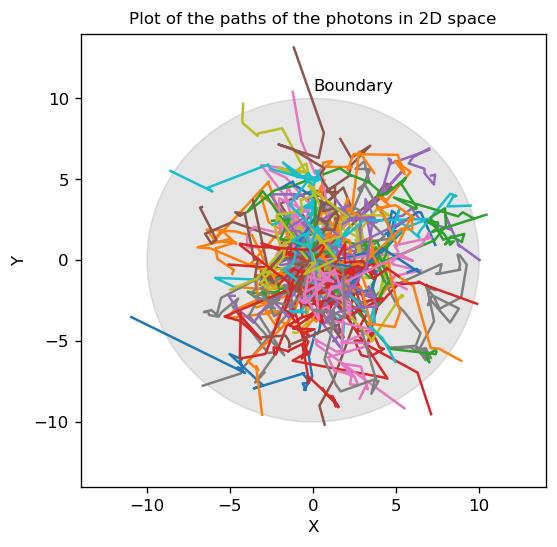

In [34]:
# Call the function
frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(10000, 2, 1, 0.95)

<b><center>(i) Varying the optical depth</b></center>

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=1000, Ndim=2
albedo=0.95, maxD=10, steps=1000


*********Results from VARYING THE OPTICAL DEPTH****************


tau 	|	FRACTIONS of ___ Photons		| 	Avg. #scatterings  | Time Required(s)

	|Absorbed 	 Escaped 	 0scattering    | Escaped 	 Absorbed  |
--------------------------------------------------------------------------------------------------
0.01	|0.0660 	 0.934 		 0.9030 	| 0.104925 	 0.106061 |  0.031009
0.05	|0.0890 	 0.911 		 0.6190 	| 0.556531 	 0.471910 |  0.041743
0.1	|0.1110 	 0.889 		 0.4090 	| 1.311586 	 1.189189 |  0.057817
0.15	|0.1540 	 0.846 		 0.2470 	| 2.215130 	 1.993506 |  0.072219
0.2	|0.2010 	 0.799 		 0.1830 	| 3.056320 	 2.641791 |  0.087790
0.25	|0.2440 	 0.756 		 0.1140 	| 4.867725 	 3.672131 |  0.134108
0.5	|0.5480 	 0.452 		 0.0540 	| 11.176991 	 8.395985 |  0.225633
0.75	|0.7340 	 0.266 		 0.0400 	| 19.875940 	 11.282016 |  0.297431
1	|0.8500 	 0.15 		 0.0480 	| 24.640000 	 14.694118 |  0.3503

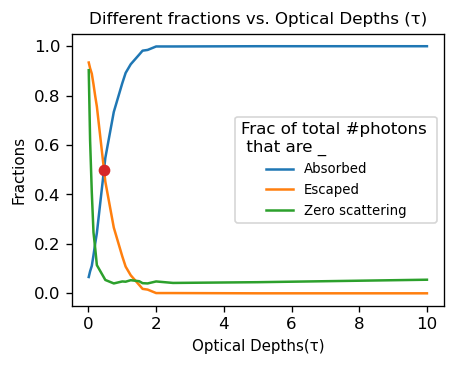

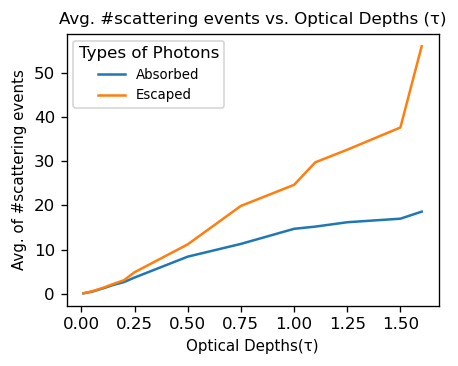

In [23]:
Nphotons = 1000
Ndim = 2
albedo = 0.95
taus = [0.01,0.05,0.1,0.15, 0.2, 0.25, 0.5, 0.75, 1,1.1,1.25, 1.5,1.6,1.75, 2, 2.5, 5, 10,50,100] 
print("Beginning MONTE CARLO RADIATIVE TRANSFER run with:")
print(f"\nNphotons={Nphotons}, Ndim={Ndim}")
print(f"albedo={albedo}, maxD=10, steps={int(1e3)}\n")
        
Abs_fracs = np.array([])
Es_fracs = np.array([])
Oscat_fracs = np.array([])

Avg_es = np.array([])
Avg_abs = np.array([])


print("\n*********Results from VARYING THE OPTICAL DEPTH****************\n\n")
print("tau \t|\tFRACTIONS of ___ Photons\t\t| \tAvg. #scatterings  | Time Required(s)\n")
print("\t|Absorbed \t Escaped \t 0scattering    | Escaped \t Absorbed  |")
print("--------------------------------------------------------------------------------------------------")
for tau in taus:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(Nphotons,Ndim, tau,albedo, verbose=False, plot=False)
    print(f"{tau}\t|{frac_ab:.4f} \t {frac_es} \t\t {frac_0sc:.4f} \t| {avg_sc_es:4f} \t {avg_sc_a:4f} |  {timeRequired:4f}")
    
    Avg_es = np.append(Avg_es, avg_sc_es)
    Avg_abs = np.append(Avg_abs, avg_sc_a)
    if tau <=10:
        Abs_fracs = np.append(Abs_fracs, frac_ab)
        Es_fracs = np.append(Es_fracs, frac_es)
        Oscat_fracs = np.append(Oscat_fracs, frac_0sc)

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(taus[:18], Abs_fracs, label='Absorbed')
plt.plot(taus[:18], Es_fracs, label='Escaped')
plt.plot(taus[:18], Oscat_fracs, label='Zero scattering')


# Find out the intersection point of the two lines in the plot
first_line = LineString(np.column_stack((taus[:18], Abs_fracs)))
second_line = LineString(np.column_stack((taus[:18], Es_fracs)))
intersection = first_line.intersection(second_line)

if intersection.geom_type == 'MultiPoint':
    plt.plot(*LineString(intersection).xy, 'o')
elif intersection.geom_type == 'Point':
    plt.plot(*intersection.xy, 'o')
x, y = intersection.xy
print(f"\nThe intersection point of the graph of both fractions (x,y) = ({x[0]:.2f},{y[0]}).\n")


plt.xlabel("Optical Depths(\u03C4)", fontsize=9), plt.ylabel("Fractions", fontsize=9)
plt.legend(fontsize=8, title="Frac of total #photons \n that are _",loc="best")#(1.09,0.1))
plt.title("Different fractions vs. Optical Depths (\u03C4)", fontsize=10)
plt.show()


plt.figure(figsize=(4, 3), dpi=120)
plt.plot(taus[:13], Avg_abs[:13], label='Absorbed')
plt.plot(taus[:13], Avg_es[:13], label='Escaped')

plt.xlabel("Optical Depths(\u03C4)", fontsize=9), plt.ylabel("Avg. of #scattering events", fontsize=9)
plt.legend(fontsize=8, title="Types of Photons",loc="best")#(1.09,0.1))
plt.title("Avg. #scattering events vs. Optical Depths (\u03C4)", fontsize=10)
plt.show()

<b><center>(ii) Varying the albedo</b></center>

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=1000, Ndim=2
tau=1, maxD=10, steps=1000


*********Results from VARYING THE ALBEDO****************


albedo 	|	FRACTIONS of ___ Photons		| 	Avg. #scatterings  | Time Required(s)

	|Absorbed 	 Escaped 	 0scattering    | Escaped 	 Absorbed  |
--------------------------------------------------------------------------------------------------
0.0	|1.0000 	 0.0 		 1.0000 	| nan 		 0.0000   |  0.0271
0.1	|1.0000 	 0.0 		 0.9070 	| nan 		 0.1030   |  0.0292
0.25	|1.0000 	 0.0 		 0.7620 	| nan 		 0.3070   |  0.0329
0.5	|0.9990 	 0.001 		 0.5200 	| 3.0000 		 0.9389   |  0.0455
0.75	|0.9990 	 0.001 		 0.2390 	| 7.0000 		 3.0541   |  0.0853
0.8	|0.9940 	 0.006 		 0.2170 	| 12.0000 		 3.7304   |  0.0996
0.85	|0.9810 	 0.019 		 0.1510 	| 14.7368 		 5.4404   |  0.1339
0.88	|0.9760 	 0.024 		 0.1120 	| 13.7500 		 7.1834   |  0.1676
0.9	|0.9710 	 0.029 		 0.0930 	| 17.2414 		 8.4902   |  0.2035
0.91	|0.9430 	 0.057 		 0.0840 	| 20.2807 		 8.9

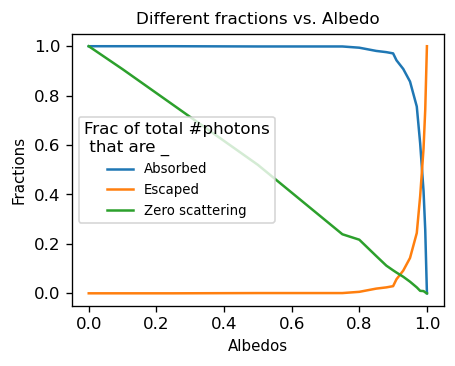

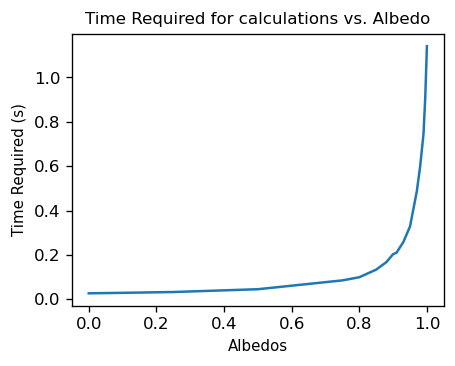

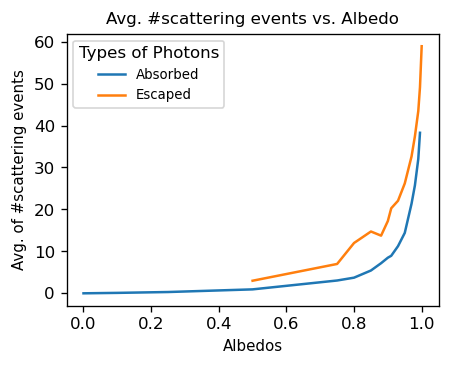

In [9]:
Nphotons = 1000
Ndim = 2
tau = 1
print("Beginning MONTE CARLO RADIATIVE TRANSFER run with:")
print(f"\nNphotons={Nphotons}, Ndim={Ndim}")
print(f"tau={tau}, maxD=10, steps={int(1e3)}\n")
        
albedos = [0.0, 0.1, 0.25, 0.5, 0.75, 0.80, 0.85, 0.88, 0.90,0.91, 0.93, 0.95,0.97, 0.98, 0.99,0.995, 1]

        
Abs_fracs = np.array([])
Es_fracs = np.array([])
Oscat_fracs = np.array([])
time_scale = np.array([])

Avg_es = np.array([])
Avg_abs = np.array([])

print("\n*********Results from VARYING THE ALBEDO****************\n\n")
print("albedo \t|\tFRACTIONS of ___ Photons\t\t| \tAvg. #scatterings  | Time Required(s)\n")
print("\t|Absorbed \t Escaped \t 0scattering    | Escaped \t Absorbed  |")
print("--------------------------------------------------------------------------------------------------")
for albedo in albedos:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(Nphotons, Ndim, tau,albedo, verbose=False, plot=False)
    print(f"{albedo}\t|{frac_ab:.4f} \t {frac_es} \t\t {frac_0sc:.4f} \t| {avg_sc_es:.4f} \t\t {avg_sc_a:.4f}   |  {timeRequired:.4f}")

      
    Avg_es = np.append(Avg_es, avg_sc_es)
    Avg_abs = np.append(Avg_abs, avg_sc_a)
    Abs_fracs = np.append(Abs_fracs, frac_ab)
    Es_fracs = np.append(Es_fracs, frac_es)
    Oscat_fracs = np.append(Oscat_fracs, frac_0sc)
    time_scale = np.append(time_scale, timeRequired)

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, Abs_fracs, label='Absorbed')
plt.plot(albedos, Es_fracs, label='Escaped')
plt.plot(albedos, Oscat_fracs, label='Zero scattering')

plt.xlabel("Albedos", fontsize=9), plt.ylabel("Fractions", fontsize=9)
plt.legend(fontsize=8,title="Frac of total #photons\n that are _",loc="best")#(1.09,0.1))
plt.title("Different fractions vs. Albedo", fontsize=10)
plt.show()


plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, time_scale)
plt.xlabel("Albedos", fontsize=9), plt.ylabel("Time Required (s)", fontsize=9)
plt.title("Time Required for calculations vs. Albedo",fontsize=10)
plt.show()

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, Avg_abs, label='Absorbed')
plt.plot(albedos, Avg_es, label='Escaped')
plt.title("Avg. #scattering events vs. Albedo", fontsize=10)
plt.xlabel("Albedos", fontsize=9), plt.ylabel("Avg. of #scattering events", fontsize=9)
plt.legend(fontsize=8, title="Types of Photons",loc="best")#(1.09,0.1))
plt.show()

<b><center>(iii) Varying the number of rays and examining the convergence of your results</b></center>

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons= varying, Ndim=2
tau=1,albedo=0.95, maxD=10, steps=1000


*********Results from VARYING THE #PHOTONS****************


#Photons |	FRACTIONS of ___ Photons		| 	Avg. #scatterings  | Time Required(s)

	|Absorbed 	 Escaped 	 0scattering    | Escaped 	 Absorbed  |
--------------------------------------------------------------------------------------------------
10	|0.6000 	 0.4 		 0.0000 	| 27.2500 		 15.1667   |  0.0047
100	|0.8000 	 0.2 		 0.0300 	| 27.5500 		 17.4125   |  0.0586
1000	|0.8660 	 0.134 		 0.0450 	| 25.7313 		 13.6640   |  0.3440
10000	|0.8584 	 0.1416 		 0.0503 	| 26.4463 		 14.3388   |  3.5673
100000	|0.8560 	 0.14401 		 0.0494 	| 25.9064 		 14.4963   |  37.7256


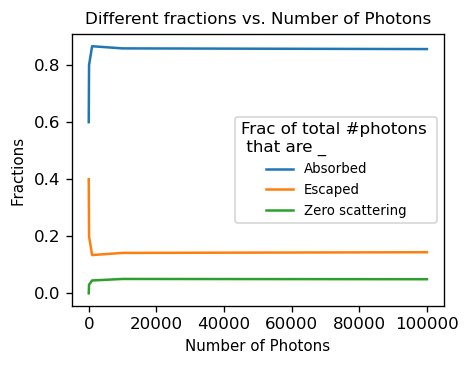

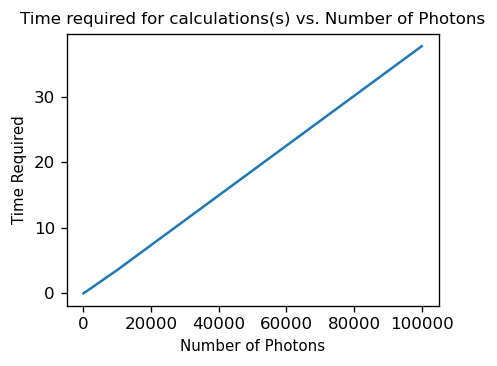

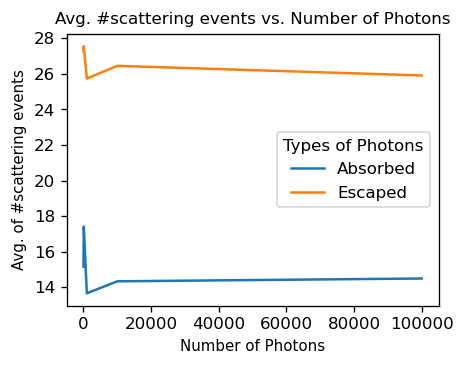

In [35]:
Ndim = 2
albedo = 0.95
tau = 1
Nphotons = [10**i for i in range(1,6,1)]
print("Beginning MONTE CARLO RADIATIVE TRANSFER run with:")
print(f"\nNphotons= varying, Ndim={Ndim}")
print(f"tau={tau},albedo={albedo}, maxD=10, steps={int(1e3)}\n")
        
Abs_fracs = np.array([])
Es_fracs = np.array([])
Oscat_fracs = np.array([])
time_scale = np.array([])


Avg_es = np.array([])
Avg_abs = np.array([])

print("\n*********Results from VARYING THE #PHOTONS****************\n\n")
print("#Photons |\tFRACTIONS of ___ Photons\t\t| \tAvg. #scatterings  | Time Required(s)\n")
print("\t|Absorbed \t Escaped \t 0scattering    | Escaped \t Absorbed  |")
print("--------------------------------------------------------------------------------------------------")
for n in Nphotons:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(n, Ndim, tau,albedo, verbose=False, plot=False)
    print(f"{n}\t|{frac_ab:.4f} \t {frac_es} \t\t {frac_0sc:.4f} \t| {avg_sc_es:.4f} \t\t {avg_sc_a:.4f}   |  {timeRequired:.4f}")
    
    Avg_es = np.append(Avg_es, avg_sc_es)
    Avg_abs = np.append(Avg_abs, avg_sc_a)
    Abs_fracs = np.append(Abs_fracs, frac_ab)
    Es_fracs = np.append(Es_fracs, frac_es)
    Oscat_fracs = np.append(Oscat_fracs, frac_0sc)
    time_scale = np.append(time_scale, timeRequired)
    

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(Nphotons, Abs_fracs, label='Absorbed')
plt.plot(Nphotons, Es_fracs, label='Escaped')
plt.plot(Nphotons, Oscat_fracs, label='Zero scattering')

plt.xlabel("Number of Photons", fontsize=9), plt.ylabel("Fractions ", fontsize=9)
plt.legend(fontsize=8,title="Frac of total #photons \n that are _",loc="best")#(1.09,0.1))
plt.title("Different fractions vs. Number of Photons",  fontsize=10)
plt.show()    

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(Nphotons, time_scale)
plt.xlabel("Number of Photons", fontsize=9), plt.ylabel("Time Required", fontsize=9)
plt.title("Time required for calculations(s) vs. Number of Photons",  fontsize=10)
plt.show()


plt.figure(figsize=(4, 3), dpi=120)
plt.plot(Nphotons, Avg_abs, label='Absorbed')
plt.plot(Nphotons, Avg_es, label='Escaped')
plt.title("Avg. #scattering events vs. Number of Photons", fontsize=10)
plt.xlabel("Number of Photons", fontsize=9), plt.ylabel("Avg. of #scattering events", fontsize=9)
plt.legend(title="Types of Photons",loc="best")#(1.09,0.1))
plt.show()



<center><h4><b>For varying number of photons from 1-1500 by 1 </center></h4></b>

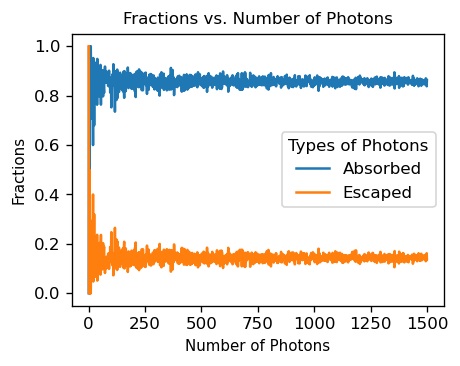

In [40]:
ns = np.arange(1,1500,1)
ys_es = np.array([])
ys_abs = np.array([])
for n in ns:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(n, Ndim, tau,albedo, verbose=False, plot=False)
    ys_es = np.append(ys_es, frac_es)
    ys_abs = np.append(ys_abs, frac_ab)
    
plt.figure(figsize=(4, 3), dpi=120)
plt.plot(ns, ys_abs, label='Absorbed')
plt.plot(ns, ys_es, label='Escaped')
plt.title("Fractions vs. Number of Photons", fontsize=10)
plt.xlabel("Number of Photons", fontsize=9), plt.ylabel("Fractions", fontsize=9)
plt.legend(title="Types of Photons",loc="best")#(1.09,0.1))
plt.show()


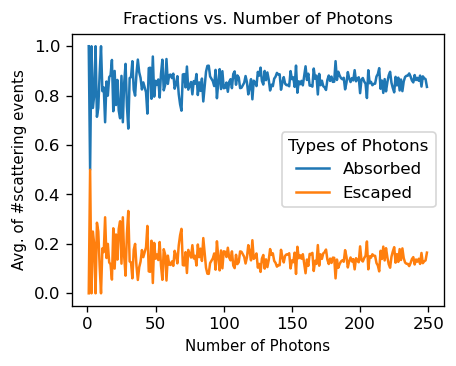

In [39]:
ns = np.arange(1,250,1)
ys_es = np.array([])
ys_abs = np.array([])
for n in ns:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(n, Ndim, tau,albedo, verbose=False, plot=False)
    ys_es = np.append(ys_es, frac_es)
    ys_abs = np.append(ys_abs, frac_ab)
    
plt.figure(figsize=(4, 3), dpi=120)
plt.plot(ns, ys_abs, label='Absorbed')
plt.plot(ns, ys_es, label='Escaped')
plt.title("Fractions vs. Number of Photons", fontsize=10)
plt.xlabel("Number of Photons", fontsize=9), plt.ylabel("Avg. of #scattering events", fontsize=9)
plt.legend(title="Types of Photons",loc="best")#(1.09,0.1))
plt.show()


<b><center>(iv)Adding additional Elements</b></center>
<b><center>a. Extension of the calculation to 3D</b></center>

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=10000, Ndim=3
tau=1, albedo=0.95, maxD=10, steps=1000

Calculation took 3.93 s

Fraction of emitted photons that are ABSORBED = 0.8706 
Fraction of emitted photons that are ESCAPED = 0.1294


Avg. number of scatterings for ABSORBED photons = 14.36469101768895
Avg. number of scatterings for ESCAPING photons = 28.042503863987637


Fraction of photons that experience zero scattering events = 0.0475




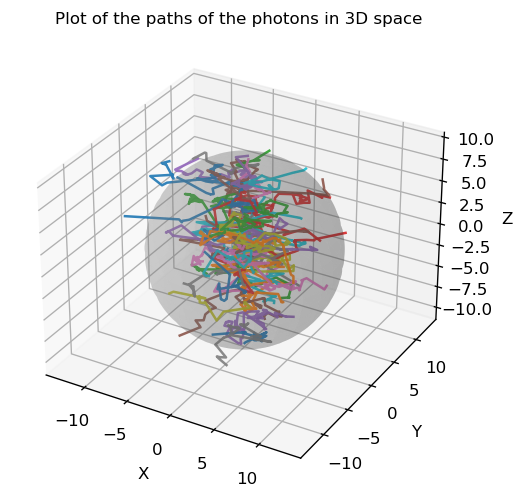

In [47]:
# Call the function
frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(10000, 3, 1, 0.95)

<center><b>Analysis for 3D: Consistency with 2D results</center></b>

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=1000, Ndim=2
albedo=0.95, maxD=10, steps=1000


*********Results from VARYING THE Optical Depths****************




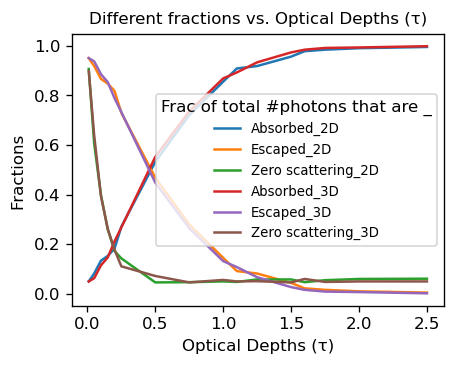

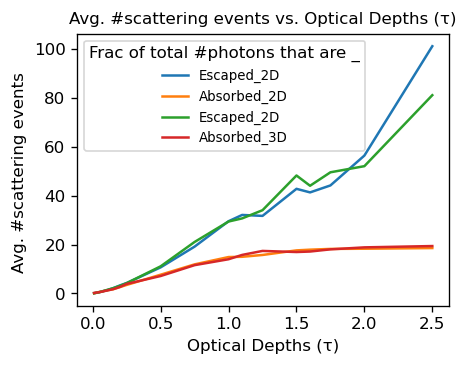

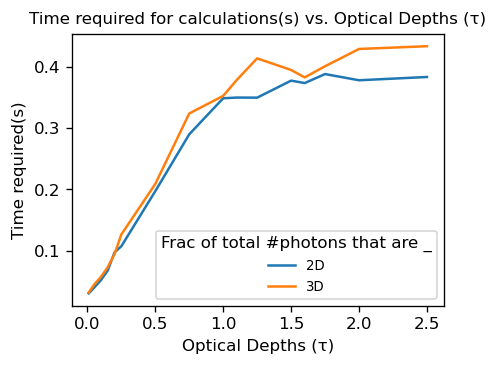

In [13]:
Nphotons = 1000
albedo = 0.95
taus = [0.01,0.05,0.1,0.15, 0.2, 0.25, 0.5, 0.75, 1,1.1,1.25, 1.5,1.6,1.75, 2, 2.5]#, 5, 10,50,100] 
print("Beginning MONTE CARLO RADIATIVE TRANSFER run with:")
print(f"\nNphotons={Nphotons}, Ndim={Ndim}")
print(f"albedo={albedo}, maxD=10, steps={int(1e3)}\n")
        

Abs_fracs = np.array([])
Es_fracs = np.array([])
Oscat_fracs = np.array([])
time_scale = np.array([])
Avg_es = np.array([])
Avg_abs = np.array([])

Abs_fracs_3 = np.array([])
Es_fracs_3 = np.array([])
Oscat_fracs_3 = np.array([])
time_scale_3 = np.array([])
Avg_es_3 = np.array([])
Avg_abs_3 = np.array([])

print("\n*********Results from VARYING THE Optical Depths****************\n\n")
# print("#Iteration |\t\t\tFRACTIONS of ___ Photons\t\t\t| \tAvg. #scatterings \t\t\t  | Time Required(s)\n")
# print("\t|Absorbed \t\t Escaped \t\t 0scattering \t\t | Escaped \t\t\t\t Absorbed  |")
# print("--------------------------------------------------------------------------------------------------------------------------------------------")
for tau in taus:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(Nphotons, 2, tau,albedo, verbose=False, plot=False)
    frac_ab_3, frac_es_3, avg_sc_a_3, avg_sc_es_3, frac_0sc_3, timeRequired_3 = MC_RadiativeTransfer(Nphotons, 3, tau,albedo, verbose=False, plot=False)
    
    #print(f"{k}\t|{frac_ab:.4f},  {frac_ab_3:.4f} \t {frac_es:.4f},  {frac_es_3:.4f} \t {frac_0sc:.4f},  {frac_0sc_3:.4f} \t| {avg_sc_es:.4f},  {avg_sc_es_3:.4f} \
    #\t {avg_sc_a:.4f},  {avg_sc_a_3:.4f}   |  {timeRequired:.4f},  {timeRequired_3:.4f}")
    
    Avg_es = np.append(Avg_es, avg_sc_es)
    Avg_abs = np.append(Avg_abs, avg_sc_a)
    Abs_fracs = np.append(Abs_fracs, frac_ab)
    Es_fracs = np.append(Es_fracs, frac_es)
    Oscat_fracs = np.append(Oscat_fracs, frac_0sc)
    time_scale = np.append(time_scale, timeRequired)
    
    Avg_es_3 = np.append(Avg_es_3, avg_sc_es_3)
    Avg_abs_3 = np.append(Avg_abs_3, avg_sc_a_3)
    Abs_fracs_3 = np.append(Abs_fracs_3, frac_ab_3)
    Es_fracs_3 = np.append(Es_fracs_3, frac_es_3)
    Oscat_fracs_3 = np.append(Oscat_fracs_3, frac_0sc_3)
    time_scale_3 = np.append(time_scale_3, timeRequired_3)
    
plt.figure(figsize=(4, 3), dpi=120)
plt.plot(taus, Abs_fracs, label='Absorbed_2D')
plt.plot(taus, Es_fracs, label='Escaped_2D')
plt.plot(taus, Oscat_fracs, label='Zero scattering_2D')
plt.plot(taus, Abs_fracs_3, label='Absorbed_3D')
plt.plot(taus, Es_fracs_3, label='Escaped_3D')
plt.plot(taus, Oscat_fracs_3, label='Zero scattering_3D')

plt.xlabel("Optical Depths (\u03C4)"), plt.ylabel("Fractions ")
plt.legend(fontsize=8,title="Frac of total #photons that are _",loc="best")#(1.09,0.1))
plt.title("Different fractions vs. Optical Depths (\u03C4)", fontsize=10)
plt.show()       

    
plt.figure(figsize=(4, 3), dpi=120)
plt.plot(taus, Avg_es, label='Escaped_2D')
plt.plot(taus, Avg_abs, label='Absorbed_2D')
plt.plot(taus, Avg_es_3, label='Escaped_2D')
plt.plot(taus, Avg_abs_3, label='Absorbed_3D')


plt.xlabel("Optical Depths (\u03C4)"), plt.ylabel("Avg. #scattering events ")
plt.legend(fontsize=8,title="Frac of total #photons that are _",loc="best")#(1.09,0.1))
plt.title("Avg. #scattering events vs. Optical Depths (\u03C4)", fontsize=10)
plt.show()       

   
plt.figure(figsize=(4, 3), dpi=120)
plt.plot(taus, time_scale, label='2D')
plt.plot(taus, time_scale_3, label='3D')


plt.xlabel("Optical Depths (\u03C4)"), plt.ylabel("Time required(s)")
plt.legend(fontsize=8,title="Frac of total #photons that are _",loc="best")#(1.09,0.1))
plt.title("Time required for calculations(s) vs. Optical Depths (\u03C4)", fontsize=10)
plt.show()       

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=10000, Ndim=2
tau=1, maxD=10, steps=1000


*********Results from VARYING ALBEDO****************




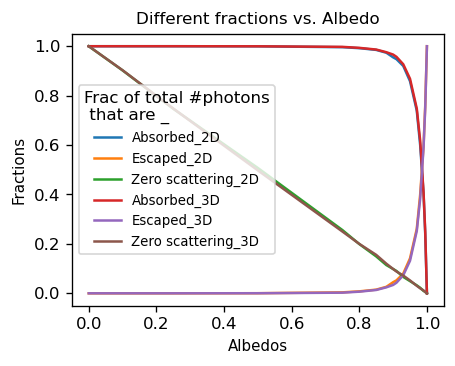

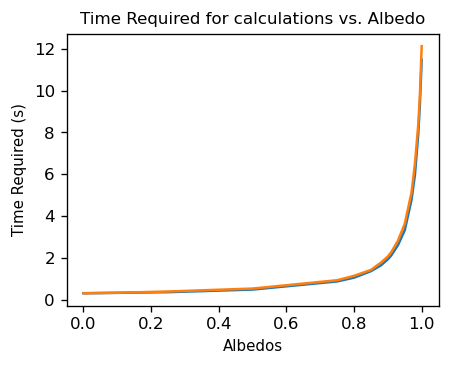

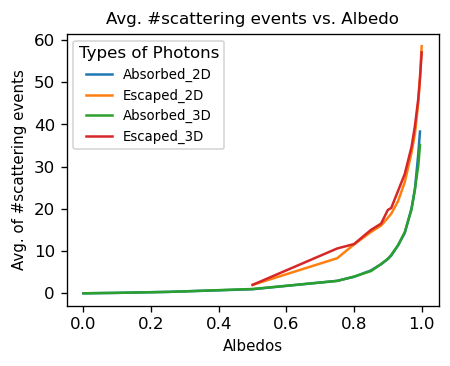

In [14]:
Nphotons = 10000
Ndim = 2
tau = 1
print("Beginning MONTE CARLO RADIATIVE TRANSFER run with:")
print(f"\nNphotons={Nphotons}, Ndim={Ndim}")
print(f"tau={tau}, maxD=10, steps={int(1e3)}\n")
        
albedos = [0.0, 0.1, 0.25, 0.5, 0.75, 0.80, 0.85, 0.88, 0.90,0.91, 0.93, 0.95,0.97, 0.98, 0.99,0.995, 1]

Abs_fracs = np.array([])
Es_fracs = np.array([])
Oscat_fracs = np.array([])
time_scale = np.array([])
Avg_es = np.array([])
Avg_abs = np.array([])

Abs_fracs_3 = np.array([])
Es_fracs_3 = np.array([])
Oscat_fracs_3 = np.array([])
time_scale_3 = np.array([])
Avg_es_3 = np.array([])
Avg_abs_3 = np.array([])

print("\n*********Results from VARYING ALBEDO****************\n\n")
# print("#Iteration |\t\t\tFRACTIONS of ___ Photons\t\t\t| \tAvg. #scatterings \t\t\t  | Time Required(s)\n")
# print("\t|Absorbed \t\t Escaped \t\t 0scattering \t\t | Escaped \t\t\t\t Absorbed  |")
# print("--------------------------------------------------------------------------------------------------------------------------------------------")
for albedo in albedos:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(Nphotons, 2, tau,albedo, verbose=False, plot=False)
    frac_ab_3, frac_es_3, avg_sc_a_3, avg_sc_es_3, frac_0sc_3, timeRequired_3 = MC_RadiativeTransfer(Nphotons, 3, tau,albedo, verbose=False, plot=False)
    
    #print(f"{k}\t|{frac_ab:.4f},  {frac_ab_3:.4f} \t {frac_es:.4f},  {frac_es_3:.4f} \t {frac_0sc:.4f},  {frac_0sc_3:.4f} \t| {avg_sc_es:.4f},  {avg_sc_es_3:.4f} \
    #\t {avg_sc_a:.4f},  {avg_sc_a_3:.4f}   |  {timeRequired:.4f},  {timeRequired_3:.4f}")
    
    Avg_es = np.append(Avg_es, avg_sc_es)
    Avg_abs = np.append(Avg_abs, avg_sc_a)
    Abs_fracs = np.append(Abs_fracs, frac_ab)
    Es_fracs = np.append(Es_fracs, frac_es)
    Oscat_fracs = np.append(Oscat_fracs, frac_0sc)
    time_scale = np.append(time_scale, timeRequired)
    
    Avg_es_3 = np.append(Avg_es_3, avg_sc_es_3)
    Avg_abs_3 = np.append(Avg_abs_3, avg_sc_a_3)
    Abs_fracs_3 = np.append(Abs_fracs_3, frac_ab_3)
    Es_fracs_3 = np.append(Es_fracs_3, frac_es_3)
    Oscat_fracs_3 = np.append(Oscat_fracs_3, frac_0sc_3)
    time_scale_3 = np.append(time_scale_3, timeRequired_3)
 

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, Abs_fracs, label='Absorbed_2D')
plt.plot(albedos, Es_fracs, label='Escaped_2D')
plt.plot(albedos, Oscat_fracs, label='Zero scattering_2D')
plt.plot(albedos, Abs_fracs_3, label='Absorbed_3D')
plt.plot(albedos, Es_fracs_3, label='Escaped_3D')
plt.plot(albedos, Oscat_fracs_3, label='Zero scattering_3D')

plt.xlabel("Albedos", fontsize=9), plt.ylabel("Fractions", fontsize=9)
plt.legend(fontsize=8,title="Frac of total #photons\n that are _",loc="best")#(1.09,0.1))
plt.title("Different fractions vs. Albedo", fontsize=10)
plt.show()


plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, time_scale,label='2D')
plt.plot(albedos, time_scale_3, label='3D')

plt.xlabel("Albedos", fontsize=9), plt.ylabel("Time Required (s)", fontsize=9)
plt.title("Time Required for calculations vs. Albedo",fontsize=10)
plt.show()

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, Avg_abs, label='Absorbed_2D')
plt.plot(albedos, Avg_es, label='Escaped_2D')
plt.plot(albedos, Avg_abs_3, label='Absorbed_3D')
plt.plot(albedos, Avg_es_3, label='Escaped_3D')
plt.title("Avg. #scattering events vs. Albedo", fontsize=10)
plt.xlabel("Albedos", fontsize=9), plt.ylabel("Avg. of #scattering events", fontsize=9)
plt.legend(fontsize=8, title="Types of Photons",loc="best")#(1.09,0.1))
plt.show()

<b><center>(iv)Adding additional Elements</b></center>
<b><center>b. Optical depth a function of the distance from the star ($\tau(s)$)</b></center>

We are calculating the distance traveled by using the exponential PDF: $\quad s = - {1 \over \tau} \ln(1 - z),\quad$ where $z$ is the random number generated from uniform distribution on [0,1).

In order to generate a new tau which is dependent on '$s$', we will use old $s$ and then generate new $\tau$ using:$\quad \tau(s) = ce^{-cs}, \quad$ where c is some constant.

Implementation: If tau_funcOFs == True, for each photon, initial tau == input_tau from function call and it will exponentially decrease as per the above mentioned function with some constant $c$ until the loop terminates for that particular photon. Again new loop will start for new photon with initial tau == input_tau and then it keeps on decreasing exponentially...repeat again....

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=1000, Ndim=2
tau=0.6999860823343379, albedo=0.95, maxD=10, steps=1000

Calculation took 0.23 s

Fraction of emitted photons that are ABSORBED = 0.518 
Fraction of emitted photons that are ESCAPED = 0.482


Avg. number of scatterings for ABSORBED photons = 10.287644787644787
Avg. number of scatterings for ESCAPING photons = 8.506224066390041


Fraction of photons that experience zero scattering events = 0.05




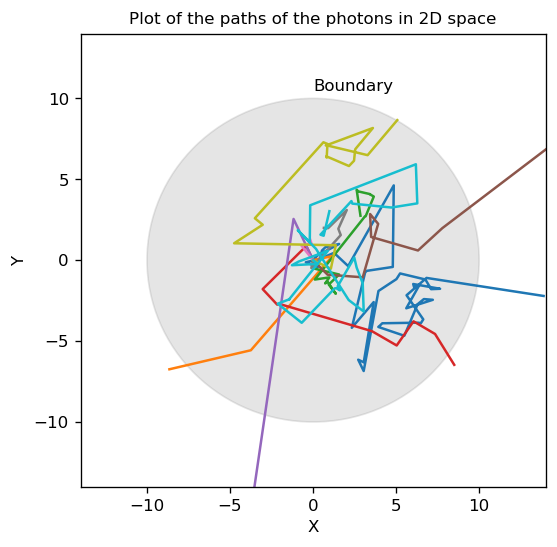

In [15]:
frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(1000, 2, 1, 0.95, tau_funcOFs=True)

Beginning MONTE CARLO RADIATIVE TRANSFER run with:

Nphotons=10000, Ndim=2
maxD=10, steps=1000


*********Results with  Optical Depths (τ) and VARYING ALBEDO****************



In every section, 1st column: constant τ, 2nd column: τ = f(s)

Albedo |			FRACTIONS of ___ Photons			| 	Avg. #scatterings 			  | Time Required(s)

	|Absorbed 		 Escaped 		 0scattering 		 | Escaped 			 Absorbed  |
--------------------------------------------------------------------------------------------------------------------------------------------
0.0	|1.0000,  1.0000 	 0.0000,  0.0000 	 1.0000,  1.0000 	| nan,  nan     	 0.0000,  0.0000   |  0.3258,  0.3484
0.1	|1.0000,  0.9989 	 0.0000,  0.0011 	 0.9031,  0.9052 	| nan,  1.0000     	 0.1068,  0.1039   |  0.3397,  0.3609
0.25	|0.9999,  0.9927 	 0.0001,  0.0073 	 0.7502,  0.7494 	| 1.0000,  1.2192     	 0.3309,  0.3192   |  0.3970,  0.4106
0.5	|0.9995,  0.9636 	 0.0005,  0.0364 	 0.5012,  0.4989 	| 4.8000,  1.5549     	 0.9989,  0.8998   |  0.5366,  0.5430


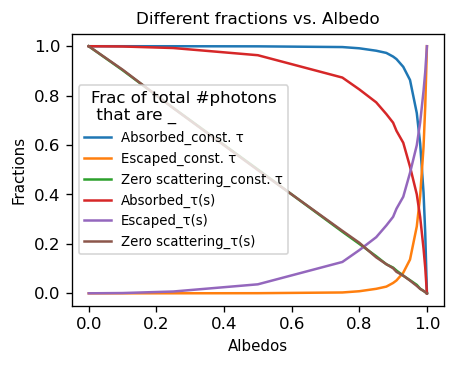

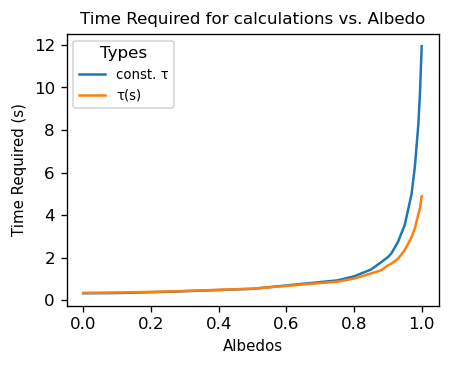

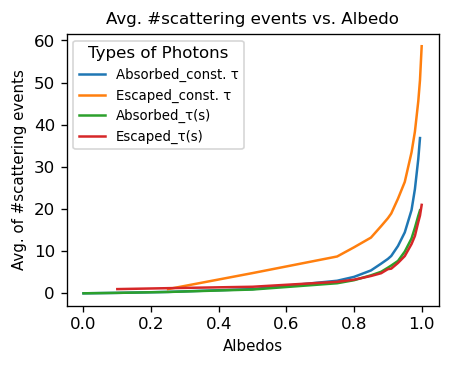

In [57]:
Nphotons = 10000
Ndim = 2
tau = 1
print("Beginning MONTE CARLO RADIATIVE TRANSFER run with:")
print(f"\nNphotons={Nphotons}, Ndim={Ndim}")
print(f"maxD=10, steps={int(1e3)}\n")
        
albedos = [0.0, 0.1, 0.25, 0.5, 0.75, 0.80, 0.85, 0.88, 0.90,0.91, 0.93, 0.95,0.97, 0.98, 0.99,0.995, 1]

Abs_fracs = np.array([])
Es_fracs = np.array([])
Oscat_fracs = np.array([])
time_scale = np.array([])
Avg_es = np.array([])
Avg_abs = np.array([])

Abs_fracs_on = np.array([])
Es_fracs_on = np.array([])
Oscat_fracs_on = np.array([])
time_scale_on = np.array([])
Avg_es_on = np.array([])
Avg_abs_on = np.array([])

print("\n*********Results with  Optical Depths (\u03C4) and VARYING ALBEDO****************\n\n")
print("\nIn every section, 1st column: constant \u03C4, 2nd column: \u03C4 = f(s)\n")
print("Albedo |\t\t\tFRACTIONS of ___ Photons\t\t\t| \tAvg. #scatterings \t\t\t  | Time Required(s)\n")
print("\t|Absorbed \t\t Escaped \t\t 0scattering \t\t | Escaped \t\t\t Absorbed  |")
print("--------------------------------------------------------------------------------------------------------------------------------------------")
for albedo in albedos:
    frac_ab, frac_es, avg_sc_a, avg_sc_es, frac_0sc, timeRequired = MC_RadiativeTransfer(Nphotons, 2, tau,albedo, verbose=False, plot=False)
    frac_ab_on, frac_es_on, avg_sc_a_on, avg_sc_es_on, frac_0sc_on, timeRequired_on = MC_RadiativeTransfer(Nphotons, 3, tau,albedo, verbose=False, plot=False, tau_funcOFs=True)
    
    print(f"{albedo}\t|{frac_ab:.4f},  {frac_ab_on:.4f} \t {frac_es:.4f},  {frac_es_on:.4f} \t {frac_0sc:.4f},  {frac_0sc_on:.4f} \t| {avg_sc_es:.4f},  {avg_sc_es_on:.4f} \
    \t {avg_sc_a:.4f},  {avg_sc_a_on:.4f}   |  {timeRequired:.4f},  {timeRequired_on:.4f}")
    
    Avg_es = np.append(Avg_es, avg_sc_es)
    Avg_abs = np.append(Avg_abs, avg_sc_a)
    Abs_fracs = np.append(Abs_fracs, frac_ab)
    Es_fracs = np.append(Es_fracs, frac_es)
    Oscat_fracs = np.append(Oscat_fracs, frac_0sc)
    time_scale = np.append(time_scale, timeRequired)
    
    Avg_es_on = np.append(Avg_es_on, avg_sc_es_on)
    Avg_abs_on = np.append(Avg_abs_on, avg_sc_a_on)
    Abs_fracs_on = np.append(Abs_fracs_on, frac_ab_on)
    Es_fracs_on = np.append(Es_fracs_on, frac_es_on)
    Oscat_fracs_on = np.append(Oscat_fracs_on, frac_0sc_on)
    time_scale_on = np.append(time_scale_on, timeRequired_on)
 

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, Abs_fracs, label='Absorbed_const. \u03C4')
plt.plot(albedos, Es_fracs, label='Escaped_const. \u03C4')
plt.plot(albedos, Oscat_fracs, label='Zero scattering_const. \u03C4')
plt.plot(albedos, Abs_fracs_on, label='Absorbed_\u03C4(s)')
plt.plot(albedos, Es_fracs_on, label='Escaped_\u03C4(s)')
plt.plot(albedos, Oscat_fracs_on, label='Zero scattering_\u03C4(s)')

plt.xlabel("Albedos", fontsize=9), plt.ylabel("Fractions", fontsize=9)
plt.legend(fontsize=8,title="Frac of total #photons\n that are _",loc="best")#(1.09,0.1))
plt.title("Different fractions vs. Albedo", fontsize=10)
plt.show()


plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, time_scale,label='const. \u03C4')
plt.plot(albedos, time_scale_on, label='\u03C4(s)')
plt.legend(fontsize=8, title="Types",loc="best")#(1.09,0.1))
plt.xlabel("Albedos", fontsize=9), plt.ylabel("Time Required (s)", fontsize=9)
plt.title("Time Required for calculations vs. Albedo",fontsize=10)
plt.show()

plt.figure(figsize=(4, 3), dpi=120)
plt.plot(albedos, Avg_abs, label='Absorbed_const. \u03C4')
plt.plot(albedos, Avg_es, label='Escaped_const. \u03C4')
plt.plot(albedos, Avg_abs_on, label='Absorbed_\u03C4(s)')
plt.plot(albedos, Avg_es_on, label='Escaped_\u03C4(s)')
plt.title("Avg. #scattering events vs. Albedo", fontsize=10)
plt.xlabel("Albedos", fontsize=9), plt.ylabel("Avg. of #scattering events", fontsize=9)
plt.legend(fontsize=8, title="Types of Photons",loc="best")#(1.09,0.1))
plt.show()